---
title: Dimensionality Reduction
format:
  html:
    css: "styles.css"
    embed-resources: true
    code-fold: true
bibliography: "Quarto_website.bib"
---

In [2]:
from sklearn.decomposition import PCA
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from __future__ import print_function
import time
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import warnings

## Explanation of Dimensionality Reduction methods

The goal of this tab is to look closer at every variable in the EPA_SmartLocationDatabase_V3_Jan_2021_Clean.csv and see which variables explain the most variance in order to understand that data set better due to its large shape (71 columns). The columns that explain the most variance will be utilized for some methods of clustering due to computational limitations of my laptop and to also visualize the clusterings calculated. This will allow us not only reduce the size of our data set while keeping the most variance but also understand the dimensionality that explains our data and visualize it in a different perspective.

### Principal Component Analysis (PCA)

Principal Component Analysis is a dimensionality reduction method that is commonly used to reduce the dimensionality of very large data sets like the one dealt in this tab. The goal is to keep as much variance as possible in the data while reducing the number of features as much as possible. For this, PCA finds the principal components of the data.

Firstly, PCA centers the data by substracting the mean of each feature. Then, PCA uses the covariance matrix to look at the relationship between variables. After this step, the eigenvector are calculated and the ones with the highes eigenvalues are determined to be the princcipal ones. By selecting the variance that we want to keep (in our case will be at least 90%) and subset the first components until that variance is explained, we are able to reduce the dimensionality of our dataset. Then, the selected components are used to produce a projection matrix by combining the eigenvectors and use it to actually transform the original data into the lower-dimensionality space [@PCA].

### t-distributed Stochastic Neighbor Embedding (t-SNE)

t-distributed Stochastic Neighbor Embedding or t-SNE is a machine learning algorithm that focusses on dimensionality reduction and visualization of high-dimensionality data. Due to its great visualization capabilities, we will specifically use this method to visualize the clusters calculated and look to see whether there is overlap or not among them (on the first two most explanatory components). 

T-SNE is particularly good at finding relationships between data points, that is why it is a great tool to visualize the clusters calculated. T-SNE models pairwise comparisons etween data points in a high-dimensional space. Then, it uses the Student's t-distribution to define the probability distribution over pairs of points in a low dimensional space and similarly define the distribution of the high-dimensional data points. After that, it focuses on reducing the divergence of the two distributions. Finally, it adjust the position of the data points to match the pairwise similarities while preserving the local relationships [@t-SNE].

### PCA vs t-SNE

PCA focuses on finding the principal components of the dataset while projecting it into a lower dimensional space. This process focusses on maintaining the most variance and rataining the pairwise distances between the data points. On the other hand, t-SNE focuses on maintaining small pairwise distances between the data points and it is not concerned with the variance of the data. Thus, for these reasons, we will use PCA to compute some of our more computational expensive clustering methods and t-SNE to visualize the clusters calculated.

## PCA

We will use PCA to determine which variables are the ones that explain the most variance of our data set. We will use the new data set obtained for some clustering methods and a better understanding of the EPA Smart Location Database dataset. For this, we will plot the explained variance based on the number of components/variables kept and choose our ideal number of components based on the variance explained.

By rule of thumb, we want to keep at least 80% of the variance. However, to be more percise, we are going to choose the number of components such that the explained variance is greater or equal to 90%.

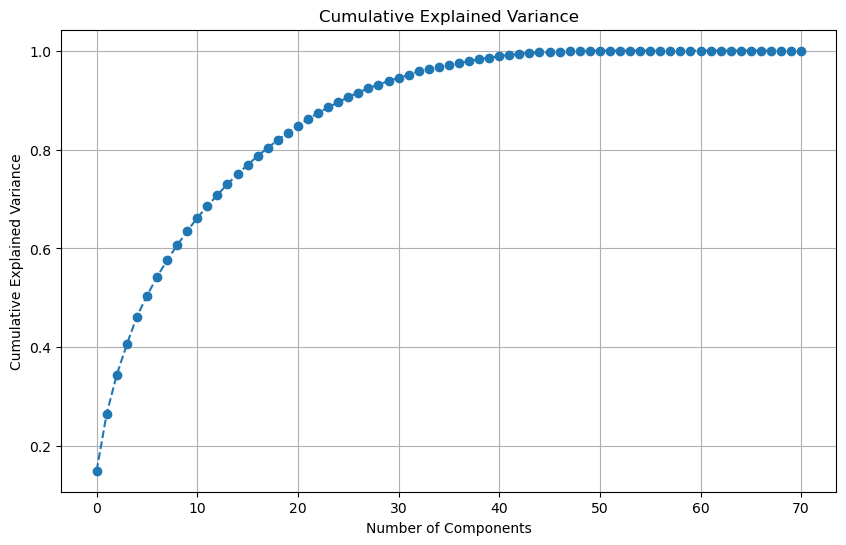

In [4]:
df=pd.read_csv('../../data/Clean_Data_project_Pub.Transport_5000/EPA_SmartLocationDatabase_V3_Jan_2021_Clean.csv',)

scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df))

pca=PCA()
pca.fit(df_scaled)

pca.explained_variance_ratio_

plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance')
plt.grid(True)
plt.show()

From this graph, we can seethat between 20 and 30 components, there is a thresshold of 90% of the variance explained. Thus, we will calculate the number of components that explain 90% of the variance in the following code chunk.

In [5]:
np.where(np.cumsum(pca.explained_variance_ratio_) > 0.9)[0][0]

25

25 components explain 90% of the variance. Thus, we will use the first 25 components to reduce the dimensionality of our data set. We will generate a new data set with the first 25 components from PCA and use it for some clustering methods and visualization. The following code will generate this new data set.

In [7]:
pca=PCA(n_components=25)
pca.fit(df_scaled)

pca.transform(df_scaled)
scores_pca = pca.transform(df_scaled)

scores_pca_df = pd.DataFrame(scores_pca, columns=[f'PC{i}' for i in range(1, scores_pca.shape[1] + 1)])
scores_pca_df.to_csv('../../data/Clean_Data_project_Pub.Transport_5000/scores_pca.csv', index=False)

We saved the new data set with the 25 components in a new csv file called EPA_SmartLocationDatabase_V3_Jan_2021_Clean_PCA.csv (located in the clean data folder). This new data set will be used for some of the clustering methods due to our computational limitations. Furthermore, it is worth noting that the columns are ordered in descending order of explained variance (the first one being the variable that explains the most of the variance and the last one the least).

## t-SNE

We will use t-SNE to visualize the data set and the clusters calculated with k-means in 2 dimensions. This will help us understand the data set better and see if there are any clusters that can be found. We will plot our data set in 2 dimensions and color the points based on the clusters calculated by k-means. However, we will do this for different perplexity values to see if there is any difference in the clusters.

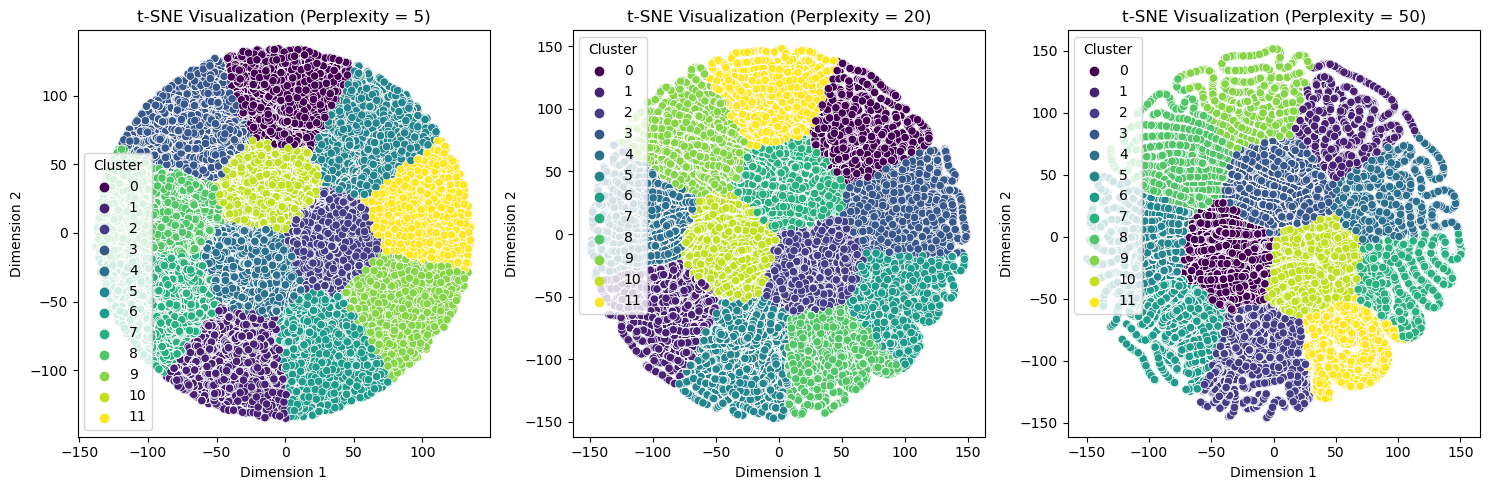

In [5]:
X = df.iloc[:, :]

warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

perplexity_values = [5, 20, 50]

kmeans = KMeans(n_clusters=12, random_state=42)

fig, axes = plt.subplots(1, len(perplexity_values), figsize=(15, 5))

for i, perplexity in enumerate(perplexity_values):

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
        X_tsne = tsne.fit_transform(X)

    clusters = kmeans.fit_predict(X_tsne)

    tsne_df = pd.DataFrame(data=X_tsne, columns=['Dimension 1', 'Dimension 2'])
    tsne_df['Cluster'] = clusters

    sns.scatterplot(x='Dimension 1', y='Dimension 2', hue='Cluster', data=tsne_df, palette='viridis', legend='full', ax=axes[i])
    axes[i].set_title(f't-SNE Visualization (Perplexity = {perplexity})')

plt.tight_layout()
plt.show()

This is a good visualization of the clusters found by k-means. More advanced methods of visualization could be done with higher computational power. However, it does not change too much from different perplexity values, which is a good sign. While the data looks like one big blob, this is probably due to the choice of the two dimensions, as we can see more clear differentiation of the clusters in the pairplots on the clustering tab. However, the clusters do not seem to overlap with eachother, which is a very good sign of the existence of clusters in the data set.

## Conclusion
We can see that there are some variables that explain the most variance in the data set. Keeping 25 out of 71 variables will preserve more than 90% of the variance, which means there is a large number of redundant variables in the data set. Furthermore, visualizing the clusters using t_SNE in 2 dimensions was very helpful to see if there was any overlap on the clusters, which there is not an aparent one. Even though it could be seen as one giant cluster, this is probably due to the dimensions chosen. However, the fact that they do not overlap supports our claim that there are clusters on the data set (as the clustering studies also support this claim).